In [1]:
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree

/Users/vychan/Coding/AIO2025/Code/aio2025_study/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Load the dataset
df = pd.read_csv(
    "./data/Student_Pass_Dataset.csv",
    names=["Điểm_Tốt_Nghiệp", "Chứng_chỉ_Ielts", "Cộng_điểm_dân_tộc", "Đậu_ĐH"],
    header=0,
)
print("Original dataset:")
display(df)

Original dataset:


,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_điểm_dân_tộc,Đậu_ĐH
0,12.0,Không,Không,Không
1,14.5,Không,Có,Không
2,16.0,Không,Không,Không
3,18.0,Không,Có,Không
4,20.0,Có,Không,Có
5,22.0,Không,Không,Không
6,24.0,Có,Có,Có
7,26.0,Không,Không,Có


In [3]:
# Step 2: Load and encode dataset
def encode_df(df):
    df2 = df.copy()
    bin_map = {"Có": 0, "Không": 1}
    df2["Chứng_chỉ_Ielts"] = df2["Chứng_chỉ_Ielts"].map(bin_map)
    df2["Cộng_điểm_dân_tộc"] = df2["Cộng_điểm_dân_tộc"].map(bin_map)
    df2["Đậu_ĐH"] = df2["Đậu_ĐH"].map({"Có": 1, "Không": 0})

    return df2


df_encoded = encode_df(df)
display(df_encoded)

,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_điểm_dân_tộc,Đậu_ĐH
0,12.0,1,1,0
1,14.5,1,0,0
2,16.0,1,1,0
3,18.0,1,0,0
4,20.0,0,1,1
5,22.0,1,1,0
6,24.0,0,0,1
7,26.0,1,1,1


In [4]:
# Step 3: Compute root entropy of the target
def gini(probs):
    return 1 - np.sum(np.square(probs))


root_probs = df_encoded["Đậu_ĐH"].value_counts(normalize=True).sort_index().values
root_gini = gini(root_probs)
print(f"Root Gini impurity của Đậu_ĐH = {root_gini:.4f}")

Root Gini impurity của Đậu_ĐH = 0.4688


In [5]:
print(df_encoded[np.array(df.columns)[1]].unique())

[1 0]


In [ ]:
# Step 4: Compute Information Gain for each feature
print("\nGini Gain cho từng thuộc tính:")
features = ["Chứng_chỉ_Ielts", "Điểm_Tốt_Nghiệp", "Cộng_điểm_dân_tộc"]
for feature in features:
    print(f"\n- Thuộc tính: {feature}")
    vals = sorted(df_encoded[feature].unique())
    if feature in ["Chứng_chỉ_Ielts", "Cộng_điểm_dân_tộc"]:
        thresholds = [0.5]
    else:
        thresholds = [(vals[i] + vals[i + 1]) / 2 for i in range(len(vals) - 1)]

    best_gain, best_thr = -1, None
    for thr in thresholds:
        left = df_encoded[df_encoded[feature] <= thr]["Đậu_ĐH"]
        right = df_encoded[df_encoded[feature] > thr]["Đậu_ĐH"]
        pL = left.value_counts(normalize=True).values
        pR = right.value_counts(normalize=True).values

        gL, gR = gini(pL), gini(pR)
        wG = (len(left) / len(df_encoded)) * gL + (len(right) / len(df_encoded)) * gR
        gain = root_gini - wG
        print(
            f"  Ngưỡng ≦ {thr}: Gini(L)={gL:.4f}, Gini(R) = {gR:.4f}, Gini trọng số: {wG:.4f}, Gain={gain:.4f}"
        )
        if gain > best_gain:
            best_gain, best_thr = gain, thr

    print(f"→ Chọn ngưỡng {best_thr} với Gini Gain = {best_gain:.4f}")



Gini Gain cho từng thuộc tính:

- Thuộc tính: Chứng_chỉ_Ielts
  Ngưỡng ≦ 0.5: Gini(L)=0.0000, Gini(R) = 0.2778, Gini trọng số: 0.2083, Gain=0.2604
→ Chọn ngưỡng 0.5 với Gini Gain = 0.2604

- Thuộc tính: Điểm_Tốt_Nghiệp
  Ngưỡng ≦ 13.25: Gini(L)=0.0000, Gini(R) = 0.4898, Gini trọng số: 0.4286, Gain=0.0402
  Ngưỡng ≦ 15.25: Gini(L)=0.0000, Gini(R) = 0.5000, Gini trọng số: 0.3750, Gain=0.0938
  Ngưỡng ≦ 17.0: Gini(L)=0.0000, Gini(R) = 0.4800, Gini trọng số: 0.3000, Gain=0.1688
  Ngưỡng ≦ 19.0: Gini(L)=0.0000, Gini(R) = 0.3750, Gini trọng số: 0.1875, Gain=0.2812
  Ngưỡng ≦ 21.0: Gini(L)=0.3200, Gini(R) = 0.4444, Gini trọng số: 0.3667, Gain=0.1021
  Ngưỡng ≦ 23.0: Gini(L)=0.2778, Gini(R) = 0.0000, Gini trọng số: 0.2083, Gain=0.2604
  Ngưỡng ≦ 25.0: Gini(L)=0.4082, Gini(R) = 0.0000, Gini trọng số: 0.3571, Gain=0.1116
→ Chọn ngưỡng 19.0 với Gini Gain = 0.2812

- Thuộc tính: Cộng_điểm_dân_tộc
  Ngưỡng ≦ 0.5: Gini(L)=0.4444, Gini(R) = 0.4800, Gini trọng số: 0.4667, Gain=0.0021
→ Chọn ngưỡng 0.

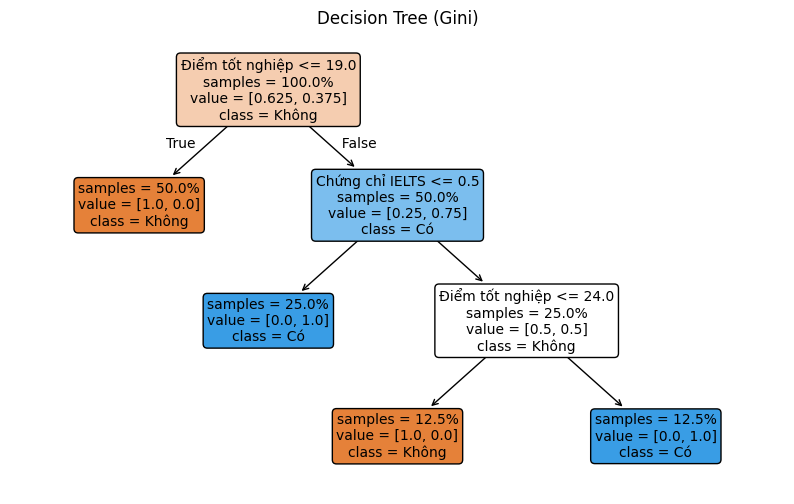

In [7]:
# Step 5: Train a full-depth tree and visualize
X = df_encoded[features]
y = df_encoded["Đậu_ĐH"]
clf = DecisionTreeClassifier(criterion="gini", random_state=0)
clf.fit(X, y)

plt.figure(figsize=(10, 6))
plot_tree(
    clf,
    feature_names=["Chứng chỉ IELTS", "Điểm tốt nghiệp", "Cộng điểm dân tộc"],
    class_names=["Không", "Có"],
    filled=True,
    rounded=True,
    proportion=True,
    impurity=False,
    fontsize=10,
)

plt.title("Decision Tree (Gini)")
plt.show()

In [ ]:
# Step 6: Test
_mapping = {"Có": 0, "Không": 1}


def encode_input(record):
    return [
        _mapping[record["Chứng_chỉ_Ielts"]],
        record["Điểm_Tốt_Nghiệp"],
        _mapping[record["Cộng_điểm_dân_tộc"]],
    ]


def predict_pass(record):
    x_list = encode_input(record)
    df_new = pd.DataFrame([x_list], columns=features)
    pred = clf.predict(df_new)[0]
    return "Có" if pred == 1 else "Không"


new_student = {
    "Điểm_Tốt_Nghiệp": 27.0,
    "Chứng_chỉ_Ielts": "Có",
    "Cộng_điểm_dân_tộc": "Không",
}

print(f"Kết quả dự đoán: {predict_pass(new_student)}")

Kết quả dự đoán: Có


In [9]:
# Demo
def predict_and_plot(diem, ielts, dan_toc):
    try:
        record = {
            "Điểm_Tốt_Nghiệp": float(diem),
            "Chứng_chỉ_Ielts": ielts,
            "Cộng_điểm_dân_tộc": dan_toc,
        }
        result = predict_pass(record)
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_tree(
            clf,
            feature_names=["Chứng chỉ IELTS", "Điểm tốt nghiệp", "Cộng điểm dân tộc"],
            class_names=["Không", "Có"],
            filled=True,
            rounded=True,
            proportion=True,
            impurity=False,
            fontsize=8,
            ax=ax,
        )
        ax.set_title("Decision Tree (Gini)")
        plt.tight_layout()

        return result, fig
    except Exception as e:
        return f"Lỗi nhập liệu: {e}", None


iface = gr.Interface(
    fn=predict_and_plot,
    inputs=[
        gr.Number(label="Điểm tốt nghiệp", value=None, placeholder="Ví dụ: 27.0"),
        gr.Radio(["Có", "Không"], label="Chứng chỉ IELTS", value="Có"),
        gr.Radio(["Có", "Không"], label="Cộng điểm dân tộc", value="Có"),
    ],
    outputs=[gr.Textbox(label="Dự đoán đậu đại học"), gr.Plot(label="Decision Tree")],
    title="DEMO student Pass Predictor (GINI)",
    description="""
    ****Hướng dẫn nhập liệu***
""",
)
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
